<a href="https://colab.research.google.com/github/annodomini80/rnn-python/blob/master/solar_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
def get_feature(new_data,
                seasonality=False,
                period=24):
  """

  Args:
    new_data:
    seasonality:
    period:
  Returns:

  """

  features = new_data[['temperature',
                      'radiation_direct_horizontal',
                      'radiation_diffuse_horizontal']]

  if seasonality:
    # Also verify that both DataFrames have the same 'utc_timestamp' format and values to ensure successful merging
    result = seasonal_decompose(new_data['solar_generation_actual'],
                                model='additive',
                                period=period)
    result.plot()
    plt.show()

    # Add components to the original DataFrame
    new_data['trend'] = result.trend
    new_data['seasonal'] = result.seasonal

    # Drop NaN values
    new_data.dropna(inplace=True)
    # Sort the data by datetime index
    new_data.sort_index(inplace=True)

    # Preprocess the data
    features = new_data[['temperature',
                        'radiation_direct_horizontal',
                        'radiation_diffuse_horizontal',
                        'trend',
                        'seasonal']]
  target = new_data['solar_generation_actual']

  return features, target

In [15]:
def data_loader(scaled_features,
                scaled_target,
                time_step=48):
  """

  Args:
    features:
    target:
    time_step:

  Returns:

  """

  # Create sequences for LSTM
  def create_dataset(features, target, time_step=1):
      """
      Create sequences for LSTM.
      """
      print(time_step)

      X, y = [], []
      for i in range(len(features) - time_step):
          X.append(features[i:(i + time_step), :])
          y.append(target[i + time_step, 0])
      return np.array(X), np.array(y)


  X, y = create_dataset(scaled_features, scaled_target, time_step=time_step)

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      shuffle=False)
  return X_train, X_test, y_train, y_test

In [16]:
def prediction_network(X_train,
                       y_train,
                       epoch = 50,
                       batch_size = 16,
                       learning_rate = 0.001):
  """

  Args:
    X_train:
    y_train:
    epoch:
    batch_size:

  Returns:

  """
  # Build the LSTM model

  model = Sequential()
  model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Use Input layer
  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(1))  # Output layer

  # Optimizer and Loss function
  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

  # Define early stopping to avoid overfitting
  early_stop = EarlyStopping(monitor='val_loss', patience=10)

  # Train the model
  model.fit(X_train,
            y_train,
            epochs=epoch,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stop],
            shuffle=False)

  return model

In [17]:
# Load your dataset

solar_data = pd.read_excel('/content/Time_Series_FR_15-19.xlsx')
weather_data = pd.read_excel('/content/weather_data_FR_15-19.xlsx')

In [18]:
## investigate the data
print(solar_data.head())
print(weather_data.head())

solar_data['utc_timestamp'] = pd.to_datetime(solar_data['utc_timestamp'])
solar_data.set_index('utc_timestamp', inplace=True)
weather_data['utc_timestamp'] = pd.to_datetime(weather_data['utc_timestamp'])
weather_data.set_index('utc_timestamp', inplace=True)

# Merge solar and weather datasets on 'date'
new_data = pd.merge(solar_data, weather_data, on='utc_timestamp')

# Drop NaN values
new_data.dropna(inplace=True)

# Sort the data by datetime index
new_data.sort_index(inplace=True)

         utc_timestamp  solar_generation_actual
0  2014-12-31 23:00:00                      NaN
1  2015-01-01 00:00:00                      NaN
2  2015-01-01 01:00:00                      NaN
3  2015-01-01 02:00:00                      NaN
4  2015-01-01 03:00:00                      NaN
         utc_timestamp  temperature  radiation_direct_horizontal  \
0  2014-12-31 23:00:00       -1.670                          0.0   
1  2015-01-01 00:00:00       -1.768                          0.0   
2  2015-01-01 01:00:00       -1.841                          0.0   
3  2015-01-01 02:00:00       -1.908                          0.0   
4  2015-01-01 03:00:00       -1.962                          0.0   

   radiation_diffuse_horizontal  
0                           0.0  
1                           0.0  
2                           0.0  
3                           0.0  
4                           0.0  


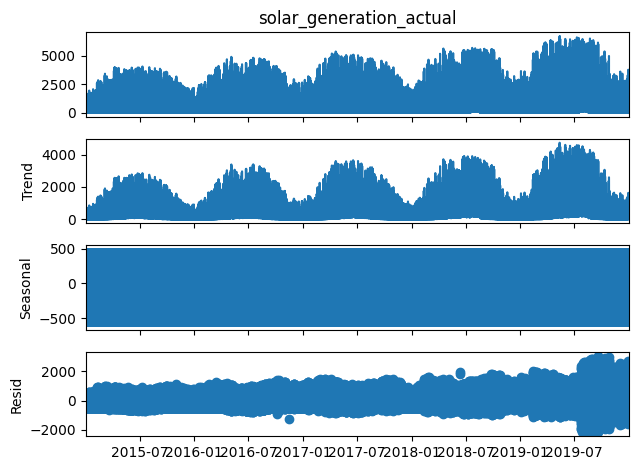

In [19]:
features, target = get_feature(new_data,
                               seasonality=True,
                               period=24)

# Scale the data
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

In [12]:
X_train, X_test, y_train, y_test = data_loader(scaled_features,
                                               scaled_target,
                                               time_step=48)

48


In [13]:
model = prediction_network(X_train,
                           y_train,
                           epoch=100,
                           batch_size=16,
                           learning_rate=0.001)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 8.2660e-04 - val_loss: 0.0014
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 6.0557e-04 - val_loss: 0.0014
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 4.8466e-04 - val_loss: 0.0016
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 4.4074e-04 - val_loss: 0.0015
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 4.0707e-04 - val_loss: 0.0011
Epoch 7/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 3.7928e-04 - val_loss: 0.0011
Epoch 8/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 3.8730e-04 - val_loss: 0.0014
Epoch 9/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 3.5972e-04 - val_loss: 9.3242e-04
Epoch 10/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 3.4559e-04 - val_loss: 0.0010
Epoch 11/100


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-66e971672b5b>", line 1, in <cell line: 1>
    model = prediction_network(X_train,
  File "<ipython-input-6-4fe556e7f4e7>", line 33, in prediction_network
    model.fit(X_train,
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 317, in fit
    callbacks.on_train_batch_begin(step)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py", line 98, in on_train_batch_begin
    def on_train_batch_begin(self, batch, logs=None):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/l

TypeError: object of type 'NoneType' has no len()

In [17]:
# Predicting the test set results
predicted_values = model.predict(X_test)

# Inverse transform the predictions to original scale
predictions_inverse = scaler_target.inverse_transform(predicted_values)
y_test_inverse = scaler_target.inverse_transform(y_test.reshape(-1, 1))


274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Mean Squared Error on Test Set: 78624.83824927134


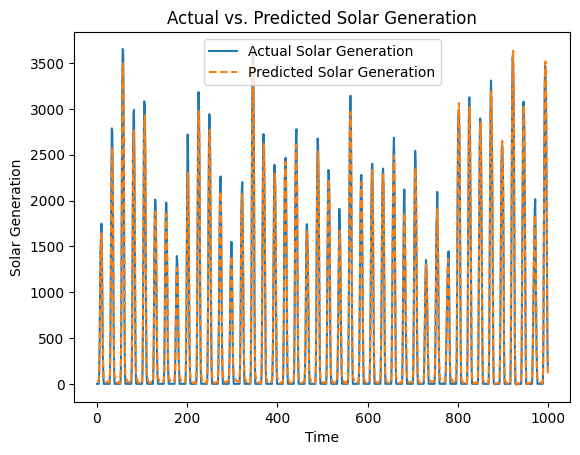

In [18]:
# Calculate Mean Squared Error on the test set
mse = mean_squared_error(y_test_inverse, predictions_inverse)
print(f'Mean Squared Error on Test Set: {mse}')

# Create the Plot
plt.plot (y_test_inverse[:1000], label='Actual Solar Generation')
plt.plot(predictions_inverse[:1000], label='Predicted Solar Generation', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Solar Generation')
plt.title('Actual vs. Predicted Solar Generation')
plt.legend()
plt.show()